### YOGA Pose Estimation

In [1]:
#import packages
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint
from pathlib import Path
import json

from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.models import resnet34
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from custom_datasets import YogaPoseDataset

import model_utils
import plot_utils

In [2]:
#import model file and define pairs of pose
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [3]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours,hierachy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

#### Finding Valid Joints pairs

In [4]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

In [5]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [6]:
#Reading the images
image1 = cv2.imread("test6.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

In [7]:
#Loading Network and pass the image through networks
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 3.8490700721740723


(-0.5, 999.5, 666.5, -0.5)

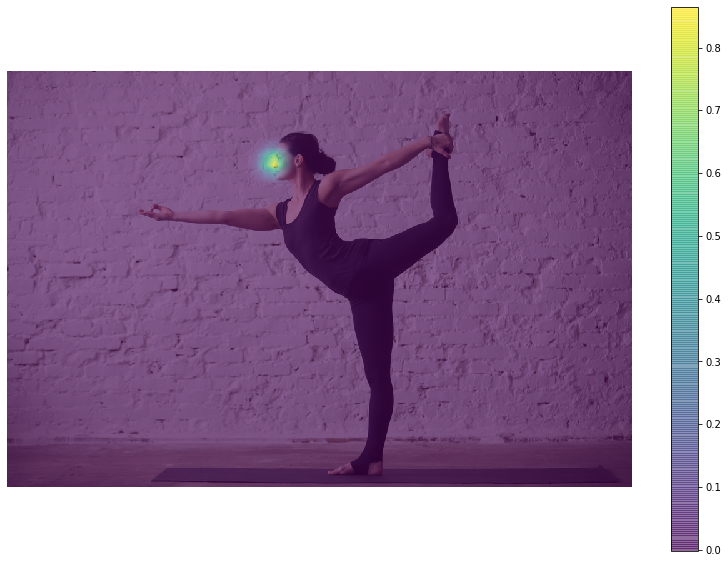

In [8]:
#getting output of heatmap
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [9]:
#Detected keypoints
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(427, 151, 0.86431396)]
Keypoints - Neck : [(472, 209, 0.7256284)]
Keypoints - R-Sho : [(441, 224, 0.82021415)]
Keypoints - R-Elb : [(341, 238, 0.6820527)]
Keypoints - R-Wr : [(267, 237, 0.64830333)]
Keypoints - L-Sho : [(514, 182, 0.71984196)]
Keypoints - L-Elb : [(601, 151, 0.83651584)]
Keypoints - L-Wr : [(673, 109, 0.8323429)]
Keypoints - R-Hip : [(558, 355, 0.44350693)]
Keypoints - R-Knee : [(587, 486, 0.46803647), (702, 253, 0.2459257)]
Keypoints - R-Ank : [(585, 616, 0.49228305)]
Keypoints - L-Hip : [(586, 341, 0.39886603)]
Keypoints - L-Knee : [(588, 486, 0.53557515)]
Keypoints - L-Ank : [(586, 629, 0.54926664)]
Keypoints - R-Eye : [(427, 138, 0.14836414)]
Keypoints - L-Eye : [(440, 137, 0.85099316)]
Keypoints - R-Ear : []
Keypoints - L-Ear : [(470, 138, 0.79481816)]


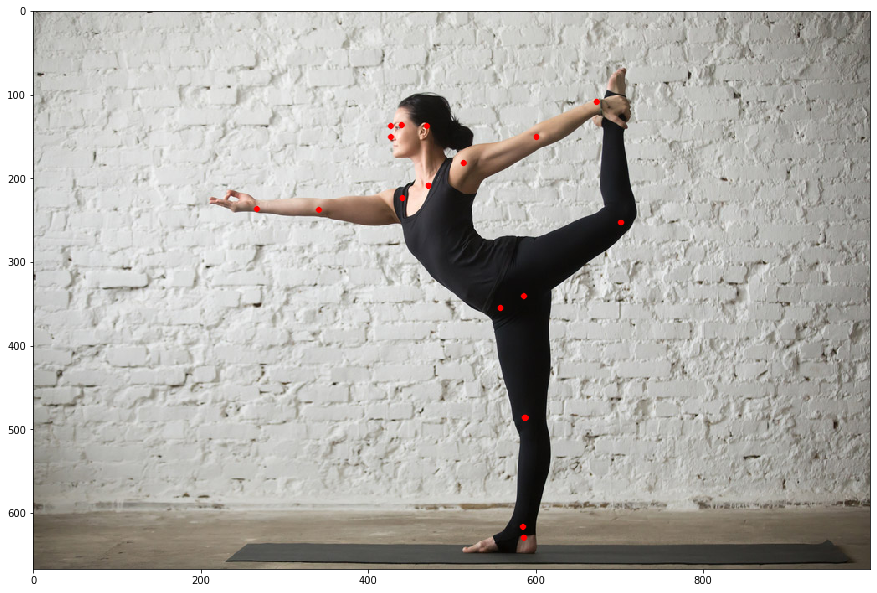

In [10]:
#Frame color
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [11]:
#Finding valid pairs
valid_pairs, invalid_pairs = getValidPairs(output)

No Connection : k = 14
No Connection : k = 18
[array([[1.        , 2.        , 0.79271123]]), array([[1.        , 5.        , 0.72209166]]), array([[2.        , 3.        , 0.87198317]]), array([[3.       , 4.       , 0.9696106]]), array([[5.        , 6.        , 0.74272937]]), array([[6.        , 7.        , 0.80497518]]), array([[1.        , 8.        , 0.77491858]]), array([[8.        , 9.        , 0.54353067]]), array([[ 9.        , 11.        ,  0.62538292]]), array([[ 1.        , 12.        ,  0.78997323]]), array([[12.        , 13.        ,  0.65588158]]), array([[13.        , 14.        ,  0.67729293]]), array([[1.        , 0.        , 0.94594962]]), array([[ 0.        , 15.        ,  0.11960381]]), [], array([[ 0.        , 16.        ,  0.88738376]]), array([[16.        , 17.        ,  1.01642318]]), array([], shape=(0, 3), dtype=float64), []]


In [12]:
#Personwise keypoints
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

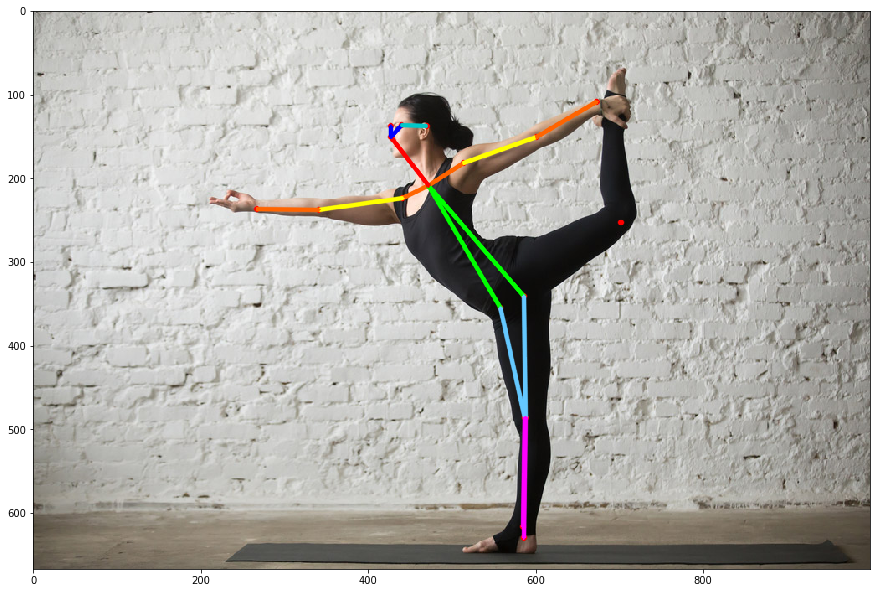

In [13]:
#showing images
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [14]:
#Directory of dataset
JPEG_DIR = Path('dataset/')

In [15]:
#Reading JSON file
pose_list = json.load(Path('pose-list-with-meta.json').open())

In [16]:
#Encode pose
pose_id_to_name = {0: 'Bharadvajasana I', 1: 'Padangusthasana', 2: 'Paripurna Navasana', 3: 'Baddha Konasana', 4: 'Dhanurasana', 5: 'Setu Bandha Sarvangasana', 6: 'Ustrasana', 7: 'Marjaryasana', 8: 'Chakravakasana', 9: 'Ashtanga Namaskara', 10: 'Utkatasana', 11: 'Balasana', 12: 'Bhujangasana', 13: 'Savasana', 14: 'Gomukhasana', 15: 'Bitilasana', 16: 'Bakasana', 17: 'Makara Adho Mukha Svanasana', 18: 'Ardha Pincha Mayurasana', 19: 'Adho Mukha Svanasana', 20: 'Garudasana', 21: 'Sukhasana', 22: 'Astavakrasana', 23: 'Utthita Hasta Padangustasana', 24: 'Uttana Shishosana', 25: 'Utthita Parsvakonasana', 26: 'Utthita Trikonasana', 27: 'Pincha Mayurasana', 28: 'Agnistambhasana', 29: 'Tittibhasana', 30: 'Matsyasana', 31: 'Chaturanga Dandasana', 32: 'Malasana', 33: 'Parighasana', 34: 'Ardha Bhekasana', 35: 'Ardha Matsyendrasana', 36: 'Supta Matsyendrasana', 37: 'Ardha Chandrasana', 38: 'Adho Mukha Vriksasana', 39: 'Ananda Balasana', 40: 'Janu Sirsasana', 41: 'Virasana', 42: 'Krounchasana', 43: 'Utthita Ashwa Sanchalanasana', 44: 'Parsvottanasana', 45: 'Viparita Karani', 46: 'Salabhasana', 47: 'Natarajasana', 48: 'Padmasana', 49: 'Anjaneyasana', 50: 'Marichyasana III', 51: 'Hanumanasana', 52: 'Tadasana', 53: 'Pasasana', 54: 'Eka Pada Rajakapotasana', 55: 'Eka Pada Rajakapotasana II', 56: 'Mayurasana', 57: 'Kapotasana', 58: 'Phalakasana', 59: 'Halasana', 60: 'Eka Pada Koundinyanasana I', 61: 'Eka Pada Koundinyanasana II', 62: 'Marichyasana I', 63: 'Supta Baddha Konasana', 64: 'Supta Padangusthasana', 65: 'Supta Virasana', 66: 'Parivrtta Janu Sirsasana', 67: 'Parivrtta Parsvakonasana', 68: 'Parivrtta Trikonasana', 69: 'Tolasana', 70: 'Paschimottanasana', 72: 'Parsva Bakasana', 73: 'Vasisthasana', 74: 'Anantasana', 75: 'Salamba Bhujangasana', 76: 'Dandasana', 77: 'Uttanasana', 78: 'Ardha Uttanasana', 79: 'Urdhva Prasarita Eka Padasana', 80: 'Salamba Sirsasana', 81: 'Salamba Sarvangasana', 82: 'Vriksasana', 83: 'Urdhva Dhanurasana', 84: 'Dwi Pada Viparita Dandasana', 85: 'Purvottanasana', 86: 'Urdhva Hastasana', 87: 'Urdhva Mukha Svanasana', 88: 'Virabhadrasana I', 89: 'Virabhadrasana II', 90: 'Virabhadrasana III', 91: 'Upavistha Konasana', 92: 'Prasarita Padottanasana', 93: 'Camatkarasana', 94: 'Yoganidrasana', 95: 'Vrischikasana', 96: 'Vajrasana', 97: 'Tulasana', 98: 'Simhasana', 99: 'Makarasana', 100: 'Lolasana', 101: 'Kurmasana', 102: 'Garbha Pindasana', 103: 'Durvasasana', 71: 'Bhujapidasana', 104: 'Bhekasana', 105: 'Bhairavasana', 106: 'Ganda Bherundasana'}

In [17]:
#Decode pose
pose_name_to_id = {'bharadvajasana i': 0, 'padangusthasana': 1, 'paripurna navasana': 2, 'baddha konasana': 3, 'dhanurasana': 4, 'setu bandha sarvangasana': 5, 'ustrasana': 6, 'marjaryasana': 7, 'chakravakasana': 8, 'ashtanga namaskara': 9, 'utkatasana': 10, 'balasana': 11, 'bhujangasana': 12, 'savasana': 13, 'gomukhasana': 14, 'bitilasana': 15, 'bakasana': 16, 'makara adho mukha svanasana': 17, 'ardha pincha mayurasana': 18, 'adho mukha svanasana': 19, 'garudasana': 20, 'sukhasana': 21, 'astavakrasana': 22, 'utthita hasta padangustasana': 23, 'uttana shishosana': 24, 'utthita parsvakonasana': 25, 'utthita trikonasana': 26, 'pincha mayurasana': 27, 'agnistambhasana': 28, 'tittibhasana': 29, 'matsyasana': 30, 'chaturanga dandasana': 31, 'malasana': 32, 'parighasana': 33, 'ardha bhekasana': 34, 'ardha matsyendrasana': 35, 'supta matsyendrasana': 36, 'ardha chandrasana': 37, 'adho mukha vriksasana': 38, 'ananda balasana': 39, 'janu sirsasana': 40, 'virasana': 41, 'krounchasana': 42, 'utthita ashwa sanchalanasana': 43, 'parsvottanasana': 44, 'viparita karani': 45, 'salabhasana': 46, 'natarajasana': 47, 'padmasana': 48, 'anjaneyasana': 49, 'marichyasana iii': 50, 'hanumanasana': 51, 'tadasana': 52, 'pasasana': 53, 'eka pada rajakapotasana': 54, 'eka pada rajakapotasana ii': 55, 'mayurasana': 56, 'kapotasana': 57, 'phalakasana': 58, 'halasana': 59, 'eka pada koundinyanasana i': 60, 'eka pada koundinyanasana ii': 61, 'marichyasana i': 62, 'supta baddha konasana': 63, 'supta padangusthasana': 64, 'supta virasana': 65, 'parivrtta janu sirsasana': 66, 'parivrtta parsvakonasana': 67, 'parivrtta trikonasana': 68, 'tolasana': 69, 'paschimottanasana': 70, 'parsva bakasana': 72, 'vasisthasana': 73, 'anantasana': 74, 'salamba bhujangasana': 75, 'dandasana': 76, 'uttanasana': 77, 'ardha uttanasana': 78, 'urdhva prasarita eka padasana': 79, 'salamba sirsasana': 80, 'salamba sarvangasana': 81, 'vriksasana': 82, 'urdhva dhanurasana': 83, 'dwi pada viparita dandasana': 84, 'purvottanasana': 85, 'urdhva hastasana': 86, 'urdhva mukha svanasana': 87, 'virabhadrasana i': 88, 'virabhadrasana ii': 89, 'virabhadrasana iii': 90, 'upavistha konasana': 91, 'prasarita padottanasana': 92, 'camatkarasana': 93, 'yoganidrasana': 94, 'vrischikasana': 95, 'vajrasana': 96, 'tulasana': 97, 'simhasana': 98, 'makarasana': 99, 'lolasana': 100, 'kurmasana': 101, 'garbha pindasana': 102, 'durvasasana': 103, 'bhujapidasana': 71, 'bhekasana': 104, 'bhairavasana': 105, 'ganda bherundasana': 106}

In [18]:
#Read classifier csv file
classifier_csv = pd.read_csv('classifier_train_data.csv')

In [19]:
#Define resize method
from PIL import ImageOps
from PIL import Image

class Resize(object):
    def __init__(self, size=224):
        self.size = size
        
    def __call__(self, im):  
        if(im.height > im.width):
            
            w = int(self.size*im.width/im.height)
            h = self.size
            pad_val = int((224-w)/2)
            pad = (224-w-pad_val,0,pad_val,0)
        else:
            h = int(self.size*im.height/im.width)
            w = self.size
            pad_val = int((224-h)/2)
            pad = (0,224-h-pad_val,0,pad_val)
        return ImageOps.expand(im.resize((w,h),resample=Image.BILINEAR), pad)

In [20]:
#Transform
bs = 32
sz = 224
n_epochs = 1
lr = 0.001

trn_tfms = transforms.Compose([
    Resize(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

val_tfms = transforms.Compose([
    Resize(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [21]:
p = transforms.ToPILImage()
#p(trn_tfms(im))

In [22]:
#Define data loader
dl = torch.utils.data.DataLoader(YogaPoseDataset('classifier_train_data.csv', trn_tfms, 
                                                           pose_id_to_name, pose_name_to_id),
                                           bs, 
                                           shuffle=True)

In [23]:
#Model read
model = resnet34(pretrained=True)
model.fc = nn.Linear(512, 107)   
model_utils.freeze_all_layers(model)
#model = model.to(device)

In [24]:
#Making require_grade is true
for param in model.parameters():
    param.requires_grad = True   

In [25]:
#Define Model
model = resnet34(pretrained=True)
model.fc = nn.Linear(512, 107)   
#model = model.to(device)
model.load_state_dict(torch.load('./models/yoga-asana-classifier.ckpt', map_location='cpu'))

<All keys matched successfully>

In [26]:
#define variable
val_tfms = transforms.Compose([
    Resize(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [27]:
#Method to evaluate image on model
def evaluate_single_image_on_model(model, val_tfms, test_img, pose_id_to_name):
    model.eval()
    with torch.no_grad():
        res = model(val_tfms(test_img)[None])
        pred_probs = torch.nn.functional.softmax(res, dim=1)[0]
        top_two = pred_probs.argsort()[-2:].numpy()
        
        res = []
        if(pred_probs[top_two[-1]]>0.8):
            res.append({'conf':round(pred_probs[top_two[-1]].item(), 2), 'pose_name': pose_id_to_name[top_two[-1]]})
        else:
            res.append({'conf':round(pred_probs[top_two[-1]].item(), 2), 'pose_name': pose_id_to_name[top_two[-1]]})
            res.append({'conf':round(pred_probs[top_two[-2]].item(), 2), 'pose_name': pose_id_to_name[top_two[-2]]})
        return res

In [28]:
#open image
test_img = Image.open('test6.jpg')

In [29]:
#call evaluate method to show name of pose
evaluate_single_image_on_model(model, val_tfms, test_img, pose_id_to_name)

[{'conf': 0.79, 'pose_name': 'Natarajasana'},
 {'conf': 0.1, 'pose_name': 'Utkatasana'}]